<a href="https://colab.research.google.com/github/YasuharuSuzuki/25_programing2/blob/main/" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 練習プログラム1
# 個人医療保険料予測

- レストランのチップ額予測モデルを参考に、個人の医療保険料予測を行ってみましょう。
- データセットに関してはGithubを参考にしてみましょう。
  - Github → https://gist.github.com/meperezcuello/82a9f1c1c473d6585e750ad2e3c05a41

## 練習プログラム1　個人医療保険料予測を行う

### ライブラリのインストール

In [ ]:
# matplotlib日本語対応ライブラリのインストール
!pip install japanize_matplotlib

### GoogleDrive の Mount

In [ ]:
# drive.mount()を使用してGoogleDriveをMount
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# os.chdir()を使用してカレントディレクトリを変更。作成したショーットカット名を使ってパスを指定します。
import os
os.chdir('/content/drive/MyDrive/＜作成したショートカット名＞')

### ライブラリのimport

In [1]:
import numpy as np # 数値演算ライブラリ
import pandas as pd # データ分析ライブラリ
import matplotlib.pyplot as plt # 可視化ライブラリ
import seaborn as sns # 可視化ライブラリ
from sklearn.preprocessing import LabelEncoder # 文字データを数字に置換するクラス（後述）
from sklearn.model_selection import train_test_split # scikit-learnの訓練データ / テストデータ 分割関数
from sklearn import linear_model # scikit-learnのlinear_modelライブラリ
from sklearn.ensemble import RandomForestRegressor  # RandomForestRegressor (回帰モデル)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # 回帰モデルの性能評価用関数

### 定数の定義
- データファイルパスを定義しておきます
- データ読み込みの際にご使用してください。修正は不要です

In [2]:
# データファイルパス定義
MEDICAL_COST_CSV = "./data/medical_cost_customized.csv"

### 練習プログラム1-1　個人医療保険料予測のデータセットを読み込む(1点)

In [3]:
# データセットを読み込み
df_medical = pd.read_csv(MEDICAL_COST_CSV, index_col=0) # 0番の列をindexに使用するため、index_col=0を指定します

### 練習プログラム1-2　読み込んだDataFrameを確認(0.5点)

#### 先頭５行のデータをざっと眺める

In [4]:
df_medical.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


- カテゴリカル変数が含まれていますね

In [5]:
df_medical['sex'].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

- 性別は男性/女性のみ

In [6]:
df_medical['smoker'].value_counts()

smoker
no     1061
yes     273
Name: count, dtype: int64

- 喫煙者かどうかも２値のみです

In [7]:
df_medical['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

- regionには上記4種のみ存在しています

### 行数、列数、データ型、欠損値の確認

In [8]:
df_medical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1334 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


### 考察
- smoker の変数が少しだけ欠損しています
- レストランのチップ予測と比較すると、1000件を超えておりデータ数が多い点は良い傾向

### 基本統計量の確認

In [9]:
df_medical.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## 考察
- bmiおよびchargesでは、75%タイルからmax値に大きな開きが発生しており、外れ値か、べき分布のデータであることが考えられます。

### 練習プログラム1-3　欠損値の対策(1点)

In [10]:
# 欠損値の数を確認
# isnull()という関数を使用して欠損値かどうかを取得し、sum()関数を用いて集計することが可能です
df_medical.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      4
region      0
charges     0
dtype: int64

- smoker 列に4件のみ存在するようです
- 量としては多くないので、そのまま削除しても良さそうです

In [11]:
# 欠損値を持つ行を確認
# any()関数を用いると欠損行を抽出できます
df_medical[df_medical.isnull().any(axis=1)]

,age,sex,bmi,children,smoker,region,charges
32,19,female,28.600,5,NaN,southwest,4687.79700
347,46,male,33.345,1,NaN,northeast,8334.45755
429,27,female,30.400,3,NaN,northwest,18804.75240
827,36,male,28.025,1,NaN,northeast,20773.62775


- 目的変数であるcharges値を確認。2σ内のため削除しても影響は少なめと思われる。

In [12]:
# 欠損値の削除
# dropna()メソッドを使用して欠損値を削除する
df_medical2 = df_medical.dropna(how='any')  # how='any'は全ての列のうちどれか１つでも欠損値を含む行を対象とすることを指定しています
df_medical2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1334 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1334 non-null   int64  
 1   sex       1334 non-null   object 
 2   bmi       1334 non-null   float64
 3   children  1334 non-null   int64  
 4   smoker    1334 non-null   object 
 5   region    1334 non-null   object 
 6   charges   1334 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.4+ KB


- 欠損値を削除した。

### 練習プログラム1-4　カテゴリカル変数の対策(0.5点)

In [13]:
categories = ['sex','smoker','region']  # カテゴリカル変数の対象とする列を指定する

df_medical3 = df_medical2.copy()  # DataFrameを書き換えるため、変換する
for category in categories:
    label_encoder = LabelEncoder()  # 文字列を数値に変換するクラスのインスタンスを作成
    label_encoder = label_encoder.fit(df_medical3[category])  # fit関数で文字列と数値の関係を取得
    df_medical3[category] = label_encoder.transform(df_medical3[category])  # transformで変換を実行
    df_medical3[category] = df_medical3[category].astype('category') # カテゴリカル変数には専用の型'category'があるため、型変換しておく
    print(df_medical3[category].value_counts())  # 変換後の値を表示

df_medical3.info()  # 型を表示

sex
1    674
0    660
Name: count, dtype: int64
smoker
0    1061
1     273
Name: count, dtype: int64
region
2    364
1    324
3    324
0    322
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1334 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1334 non-null   int64   
 1   sex       1334 non-null   category
 2   bmi       1334 non-null   float64 
 3   children  1334 non-null   int64   
 4   smoker    1334 non-null   category
 5   region    1334 non-null   category
 6   charges   1334 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 56.5 KB


- object型（文字列）が無くなり、categoryになった

### 練習プログラム1-5　相関係数の表示(1点)

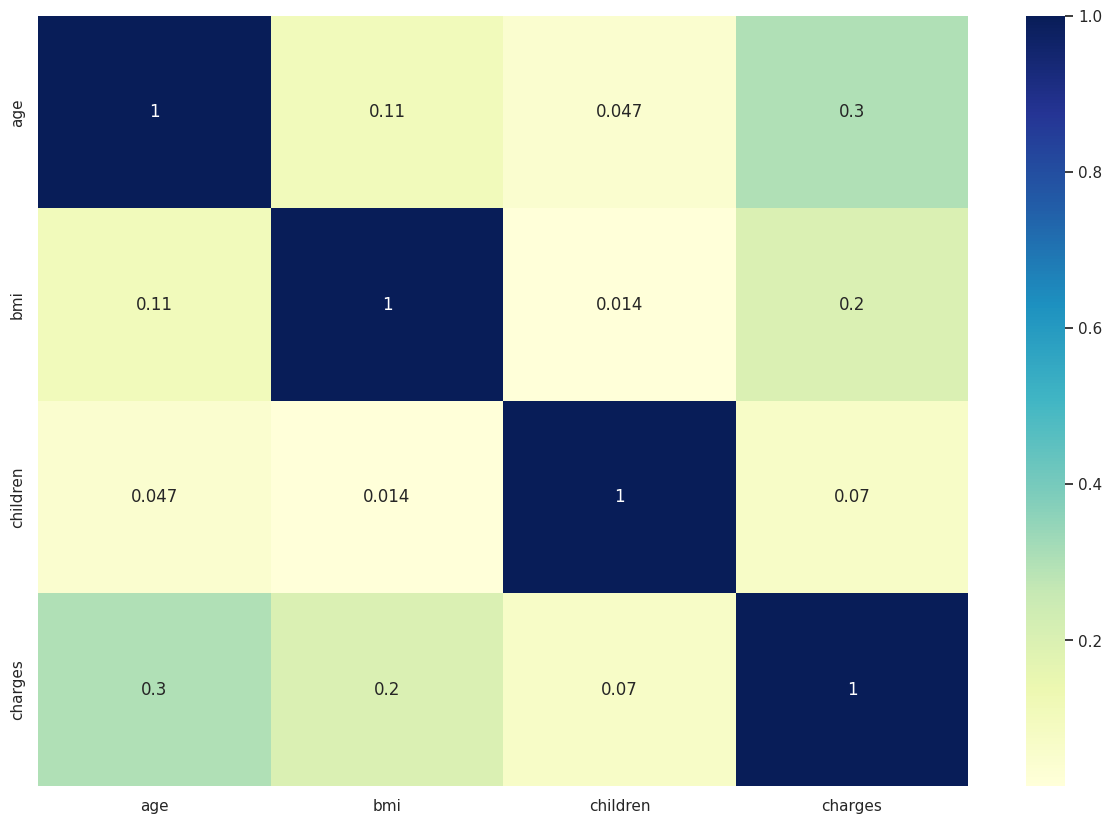

In [14]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(df_medical3.loc[:,['age','bmi','children','charges']].corr(), annot=True, cmap="YlGnBu") # カテゴリカル変数は除いて表示
plt.show()

### 考察
- ある程度相関はあるものの、強いとまでは言えないぐらいの相関。
- ageとbmiにchargesが影響するのも理解できる。ある程度納得の行く結果と言えるが、もう少し相関があると良かった。

### 練習プログラム1-6　ヒストグラムの表示(0.5点)

<Axes: >

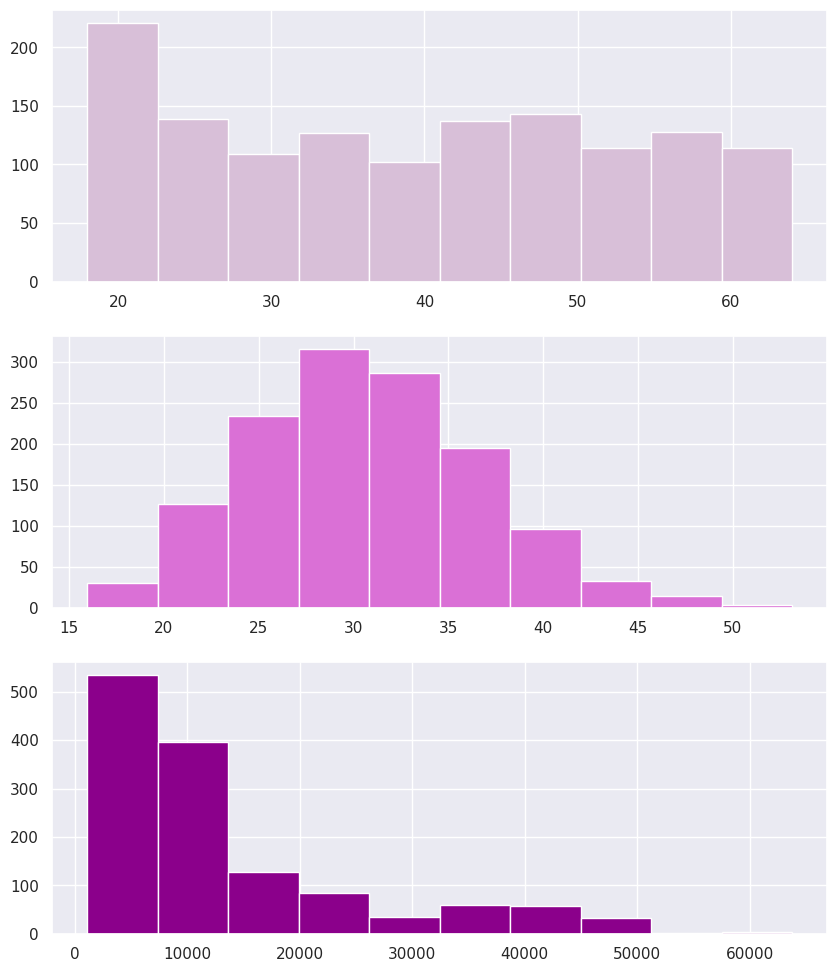

In [15]:
# ヒストグラムの表示
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
df_medical3['age'].hist(color='thistle', ax=axes[0])
df_medical3['bmi'].hist(color='orchid', ax=axes[1])
df_medical3['charges'].hist(color='darkmagenta', ax=axes[2])

### 考察
- ageは一様分布、bmiはほぼ正規分布、chargesはべき分布
- chargesは裾野が広い分布のため、分布を仮定して外れ値を除去するのは辞めておいたほうが良さそうです

### 練習プログラム1-7　多変量連関図の表示(1点)

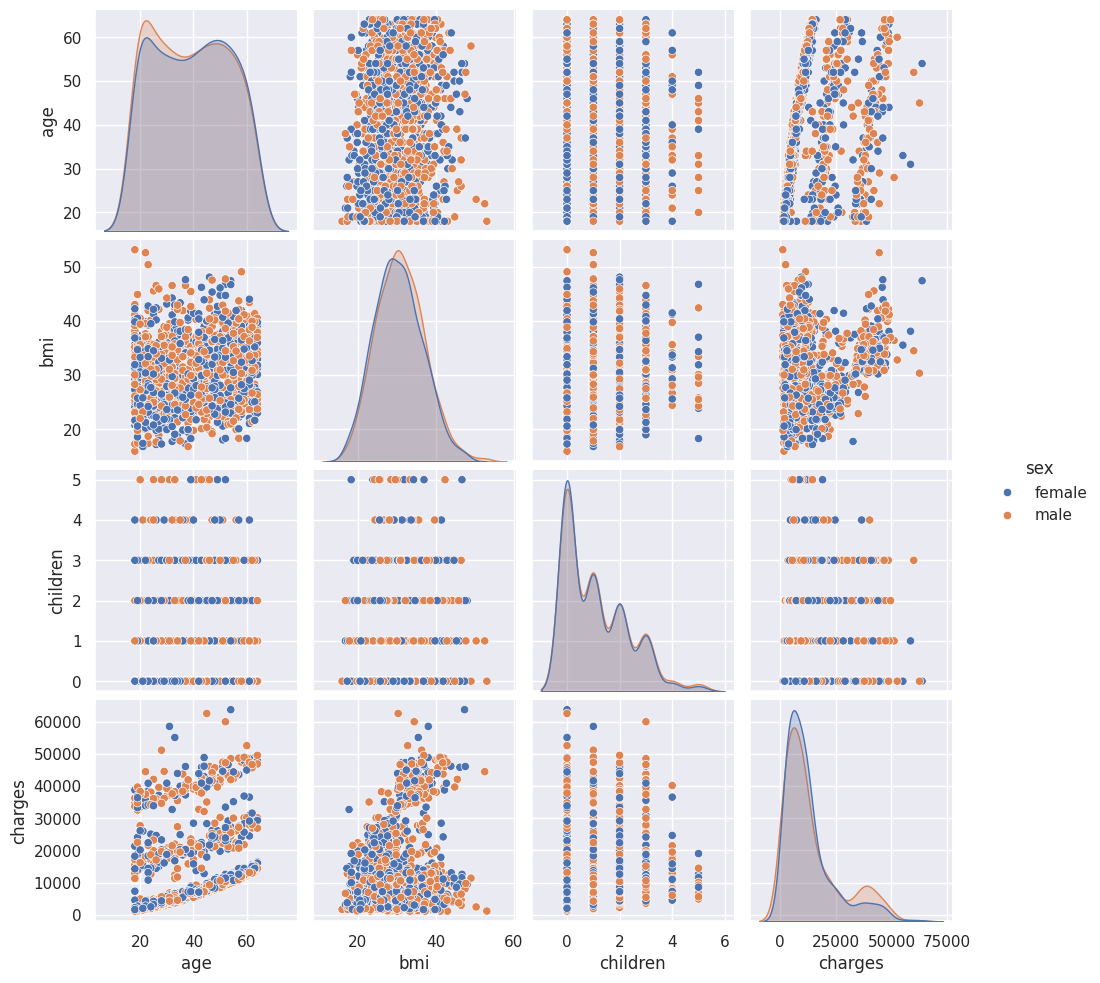

In [16]:
# 性別で層別してplot
sns.pairplot(df_medical2[['age','bmi','children','charges','sex']], hue='sex')

### 考察
- 男女であまり差が見られないのですが、ageとchargesの分布が3階層になっているのすごく気になります

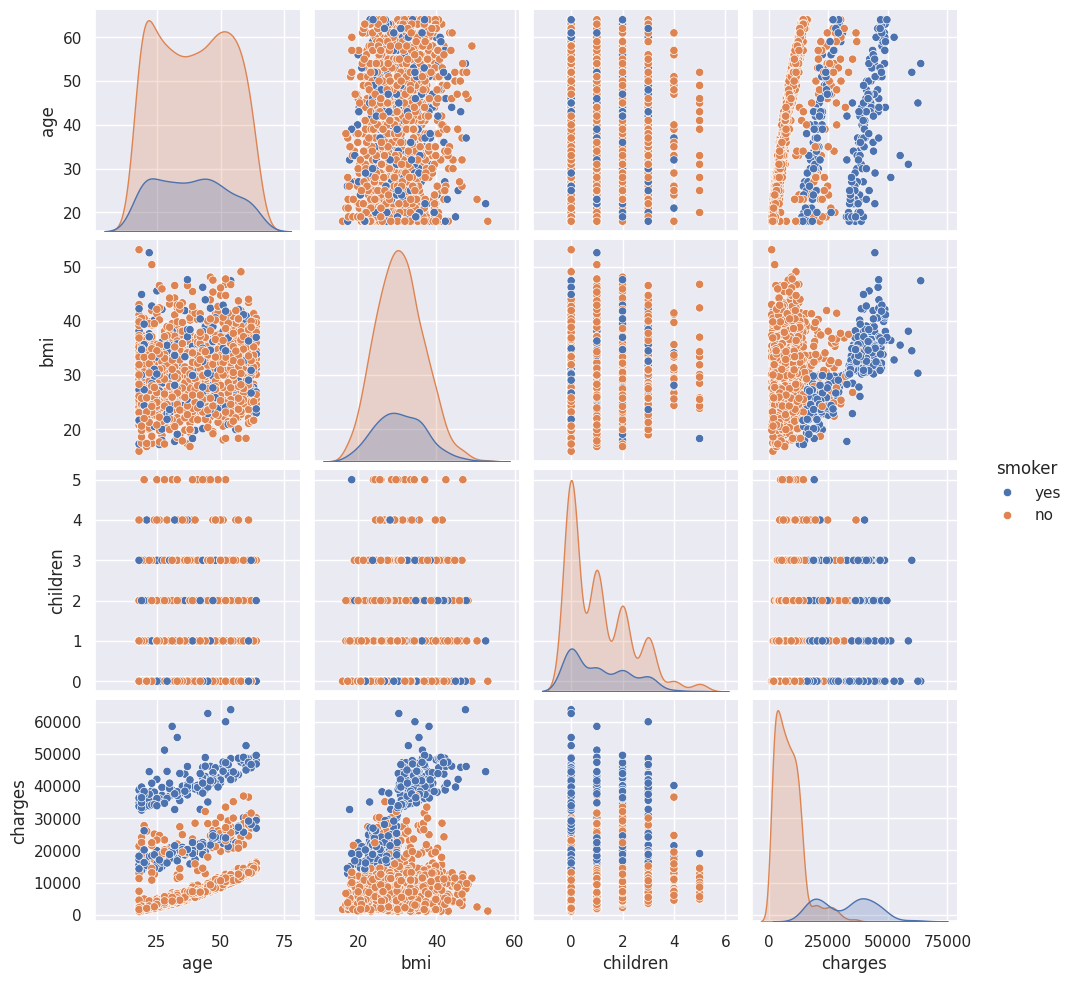

In [17]:
# 喫煙者かどうかで層別してplot
sns.pairplot(df_medical2[['age','bmi','children','charges','smoker']], hue='smoker')

### 考察
- ageとchargesの3階層のうち、2階層はsmokerの値がyesかnoかで明白に分かれそうです

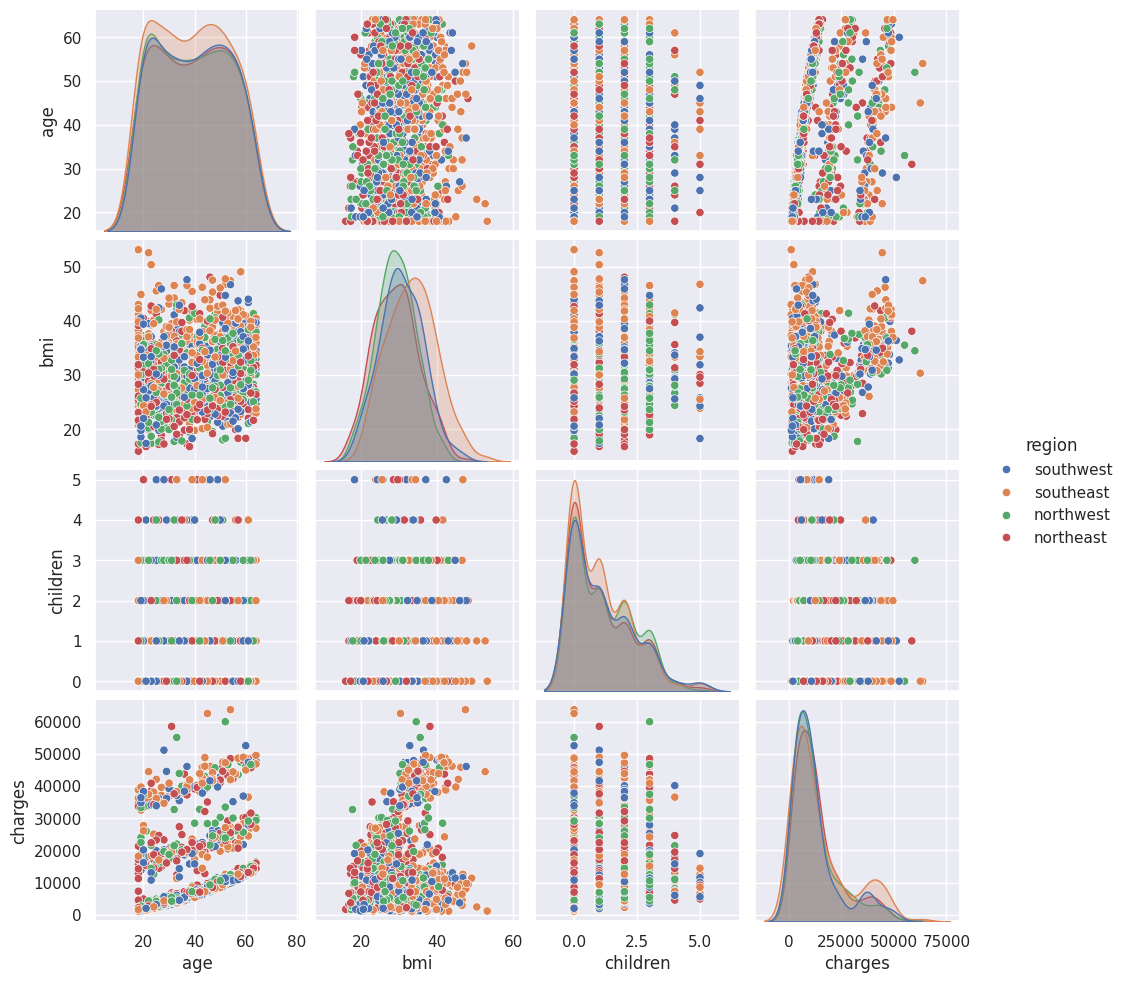

In [18]:
# 地域で層別してplot
sns.pairplot(df_medical2[['age','bmi','children','charges','region']], hue='region')

### 考察
- 地域ではそれほど差が無さそうですね

### 練習プログラム1-8　回帰モデルを作る(LinearRegression) (0.5点)

In [19]:
# 説明変数と目的変数に分ける
X = df_medical3.iloc[:,:-1]
y = df_medical3.iloc[:,-1]

# 訓練データとテストデータに分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# LinearRegressionで学習させる
ln_model = linear_model.LinearRegression()    # 回帰モデルを作る
ln_model.fit(X_train, y_train)    # 訓練する

LinearRegression()

### 練習プログラム1-9　エラーレートと決定係数によるモデルの評価(LinearRegression) (0.5点)

In [21]:
# エラーレートと決定係数の算出を行うユーザー定義関数
def evaluate_metrics(y_train_pred, y_test_pred):
    # 学習時スコア
    train_MAE = mean_absolute_error(y_train, y_train_pred)
    train_MSE = mean_squared_error(y_train, y_train_pred)
    train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_R2 = r2_score(y_train, y_train_pred)
    
    # テスト時スコア
    test_MAE = mean_absolute_error(y_test, y_test_pred)
    test_MSE = mean_squared_error(y_test, y_test_pred)
    test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_R2 = r2_score(y_test, y_test_pred)
    
    print("学習時スコア(train score)")
    print("　平均絶対誤差: ", train_MAE)
    print("　平均二乗誤差: ", train_MSE)
    print("　二乗平均平方根誤差: ", train_RMSE)
    print("　決定係数R^2: ", train_R2)
    
    print("テストスコア(test score)")
    print("　平均絶対誤差: ", test_MAE)
    print("　平均二乗誤差: ", test_MSE)
    print("　二乗平均平方根誤差: ", test_RMSE)
    print("　決定係数R^2: ", test_R2)

In [22]:
y_train_pred = ln_model.predict(X_train)  # 学習データを使って推論する
y_test_pred = ln_model.predict(X_test)  # テストデータを使って推論する

evaluate_metrics(y_train_pred, y_test_pred)

学習時スコア(train score)
　平均絶対誤差:  4037.6275343014368
　平均二乗誤差:  34783334.168543726
　二乗平均平方根誤差:  5897.7397508319855
　決定係数R^2:  0.7654786758573293
テストスコア(test score)
　平均絶対誤差:  4316.284017268299
　平均二乗誤差:  40801708.47263143
　二乗平均平方根誤差:  6387.621503551336
　決定係数R^2:  0.7153592693840074


### 考察
- 初期段階としては比較的高いスコアが出たかなと思います
- 学習時スコアとテストスコアでそれほど差が無いのも良い傾向ですね

### 練習プログラム1-10　残差の可視化によるモデル評価(LinearRegression) (0.5点)

In [23]:
# 残差の可視化を行うユーザー定義関数
def residual_plot(y_train_pred, y_test_pred):
    df_train = pd.DataFrame(y_train)
    df_train['y_train_pred'] = y_train_pred
    
    df_test = pd.DataFrame(y_test)
    df_test['y_test_pred'] = y_test_pred
    
    ax = plt.gca()
    
    # 傾き1の直線を追加
    a_line=[min(df_train['charges'].min(), df_test['charges'].min()), max(df_train['charges'].max(), df_test['charges'].max())]
    sns.regplot(x=df_train['charges'], y=df_train['y_train_pred'],label='train')
    sns.regplot(x=df_test['charges'], y=df_test['y_test_pred'],label='test')
    sns.regplot(x=a_line, y=a_line,ci=None, scatter=False, line_kws={'color': 'orange', 'linestyle': '--', 'lw': 1},label='residual 0')
    
    ax.set_xlabel('true')
    ax.set_ylabel('pred')
    
    plt.legend(fontsize=10)
    plt.show()

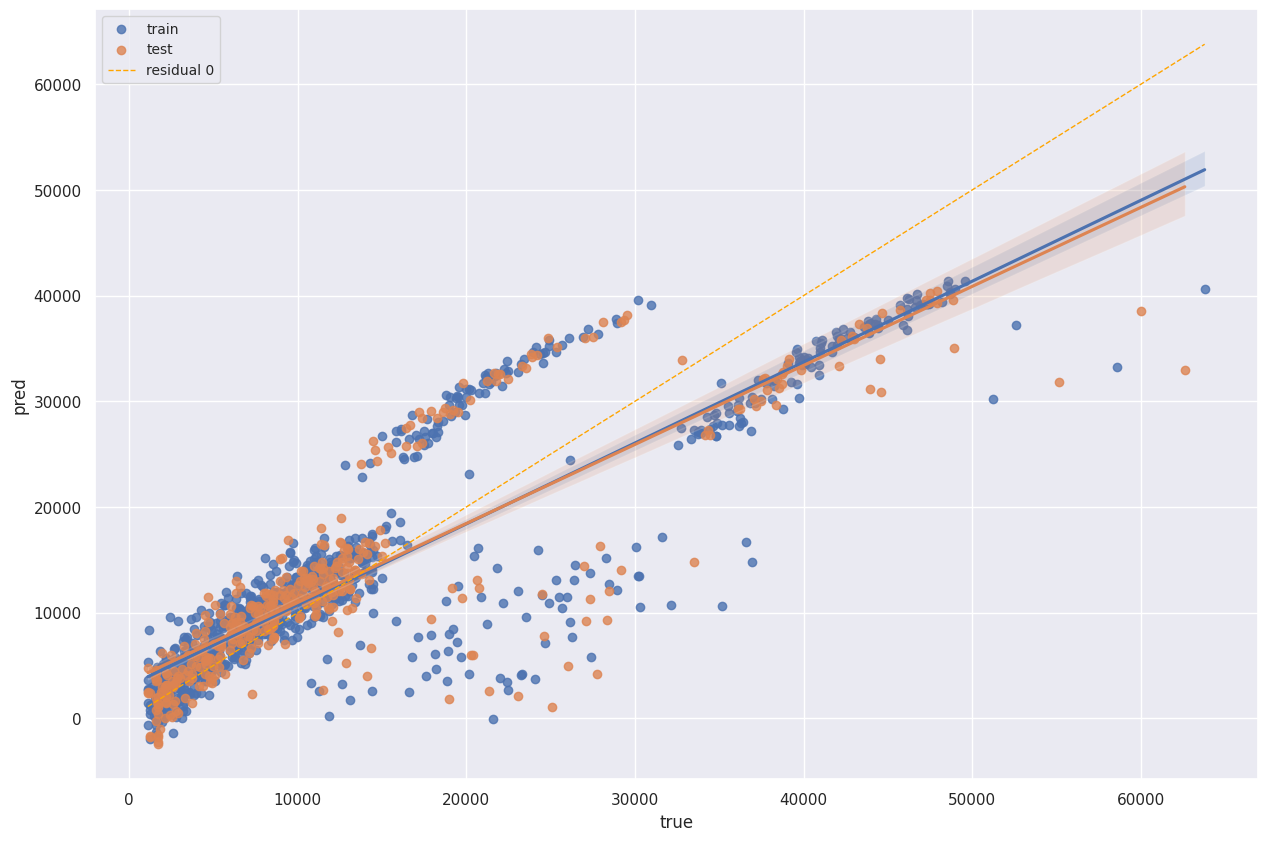

In [24]:
# 残差の可視化を行うユーザー定義関数を呼び出す
residual_plot(y_train_pred, y_test_pred)

### 考察
- 明らかに大きな分布が３つと、疎らな分布が１～２つあるように見えます
  - 4～5つに層別してあげると良さそうです
- 学習とテストではあまり差異が発生していない
  - テストの残差は学習時と同様の傾向となっており、それほど過学習はしていないように見えます

### 練習プログラム1-11　回帰モデルを作る(LinerRegression以外を使用) (0.5点)

In [25]:
# 学習する
rf_model = RandomForestRegressor(max_depth=3)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3)

### 練習プログラム1-12 エラーレートと決定係数によるモデルの評価(LinerRegression以外を使用) (0.5点)

In [26]:
y_train_pred = rf_model.predict(X_train)  # 学習データを使って推論する
y_test_pred = rf_model.predict(X_test)  # テストデータを使って推論する

evaluate_metrics(y_train_pred, y_test_pred)

学習時スコア(train score)
　平均絶対誤差:  2545.093857438151
　平均二乗誤差:  18925912.252848696
　二乗平均平方根誤差:  4350.392195290982
　決定係数R^2:  0.8723949239414762
テストスコア(test score)
　平均絶対誤差:  2684.2407778434263
　平均二乗誤差:  22253347.386633027
　二乗平均平方根誤差:  4717.345374957512
　決定係数R^2:  0.8447562786977042


### 考察
- 全体的にLinearRegressionよりも良い傾向
- エラーレート（MAE、MSE、RMSE）は概ね学習時の方が低く、テスト時の方が高いため過学習は起きていないように見える
- 決定係数は学習時のほうが高い点も同様

### 練習プログラム1-13　残差の可視化によるモデル評価(LinerRegression以外を使用) (0.5点)

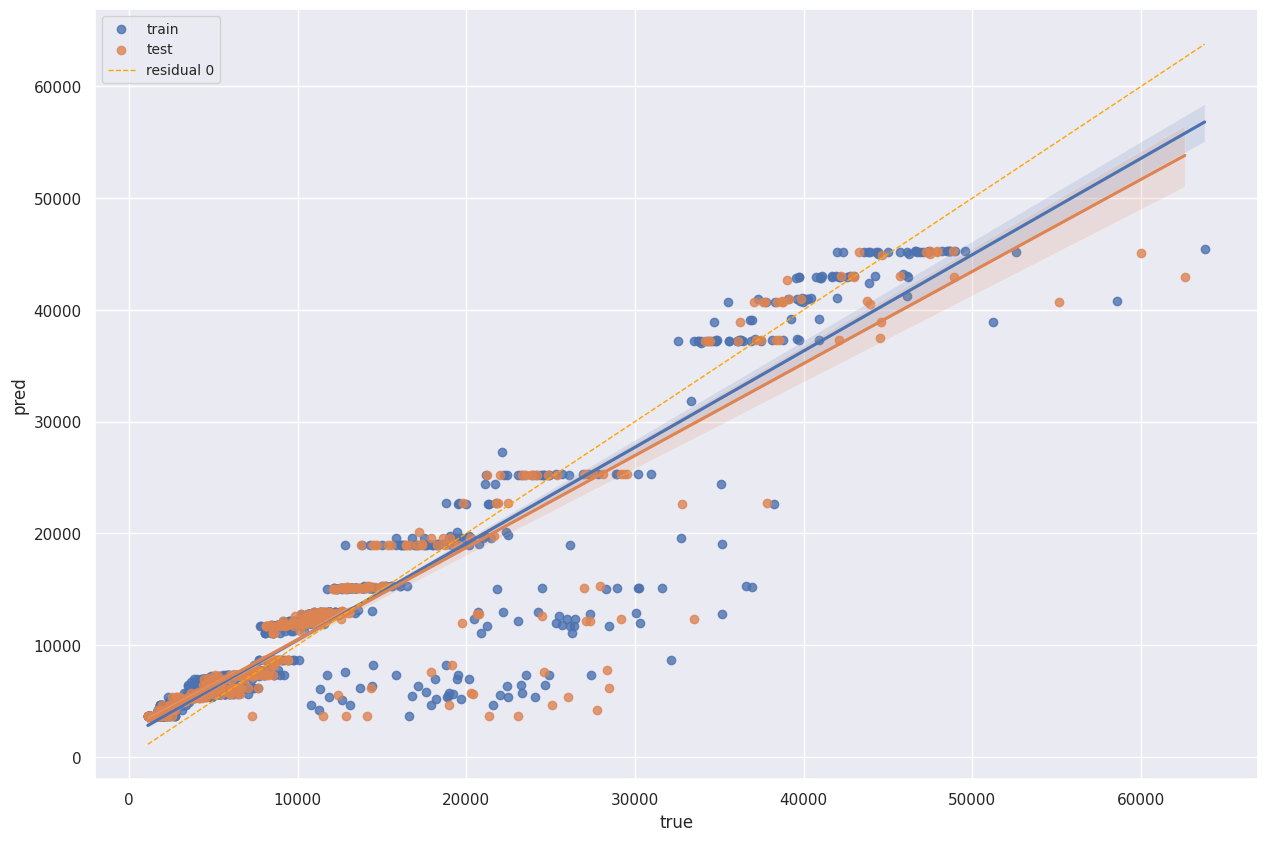

In [27]:
# 残差の可視化を行うユーザー定義関数を呼び出す
residual_plot(y_train_pred, y_test_pred)

### 考察
- 決定木系特有の段階的なplotが見られる
- max_depthを増やしたり、XGBoostやLightGBMなどの高度なモデルを使用するのも良さそうである

### さらなる精度改善1 (ボーナス+1点)
- この練習プログラムは加点要素です。ネットを検索してこれまでとは違うモデルやパラメータ、前処理等を行い、精度改善にトライしてみましょう。
- 例：RandomForestRegressorを使用してmax_depthを増やすトライ

学習時スコア(train score)
　平均絶対誤差:  2085.8003315607416
　平均二乗誤差:  14158112.066420069
　二乗平均平方根誤差:  3762.7266797390516
　決定係数R^2:  0.9045410893306502
テストスコア(test score)
　平均絶対誤差:  2689.3136206598665
　平均二乗誤差:  23393156.52619018
　二乗平均平方根誤差:  4836.647240205779
　決定係数R^2:  0.8368047463136141


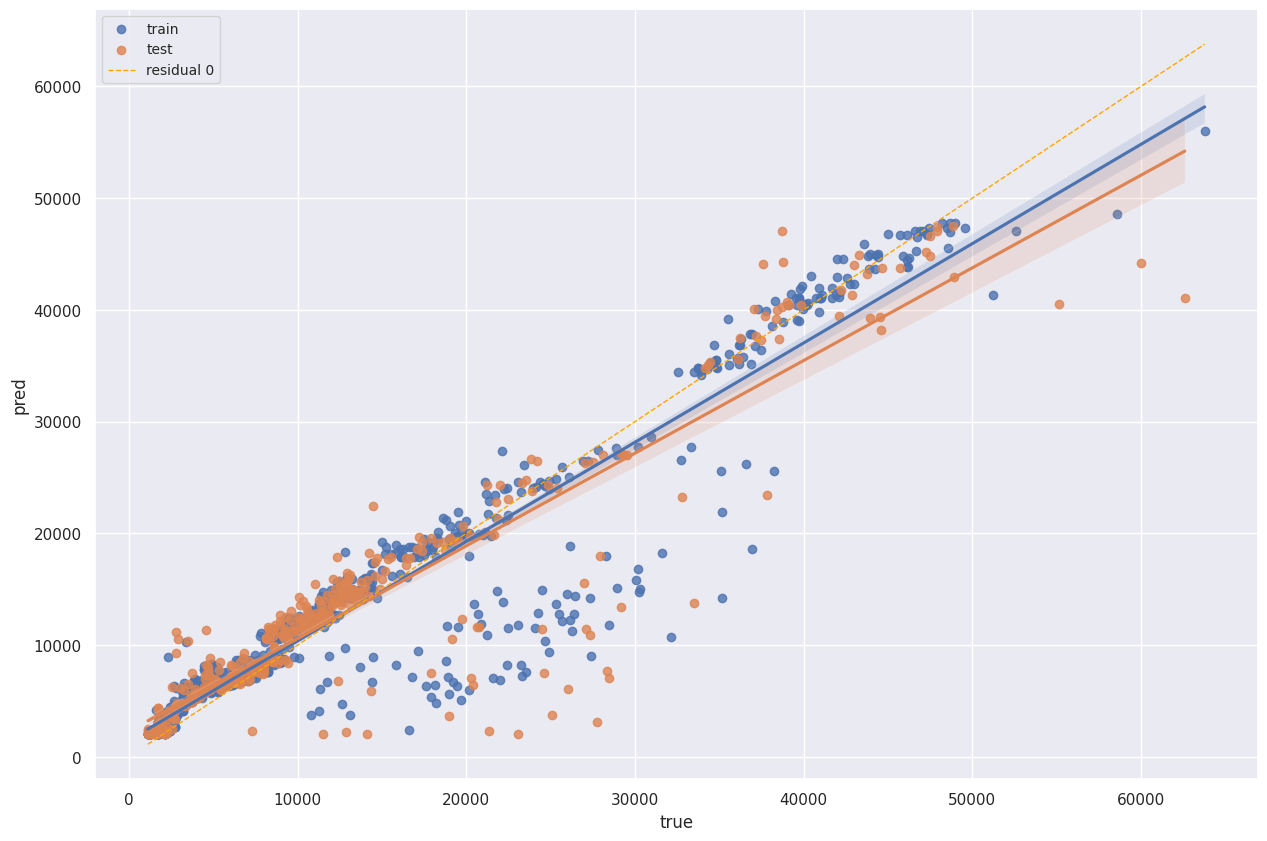

In [28]:
# 学習する
rf_model2 = RandomForestRegressor(max_depth=5)
rf_model2.fit(X_train, y_train)

y_train_pred = rf_model2.predict(X_train)  # 学習データを使って推論する
y_test_pred = rf_model2.predict(X_test)  # テストデータを使って推論する

evaluate_metrics(y_train_pred, y_test_pred)

# 残差の可視化を行うユーザー定義関数を呼び出す
residual_plot(y_train_pred, y_test_pred)

### 考察
- 過学習して決定係数が下がってしまいましたね。

### さらなる精度改善2 (ボーナス+1点)
- この練習プログラムは加点要素です。ネットを検索してこれまでとは違うモデルを使い、精度改善にトライしてみましょう。
- 例：XGBoostを使用するトライ

学習時スコア(train score)
　平均絶対誤差:  1646.9532416274262
　平均二乗誤差:  8417487.86155591
　二乗平均平方根誤差:  2901.2907233774263
　決定係数R^2:  0.9432463722516801
テストスコア(test score)
　平均絶対誤差:  2918.76971524312
　平均二乗誤差:  26668717.38136917
　二乗平均平方根誤差:  5164.176350723237
　決定係数R^2:  0.8139537905596242


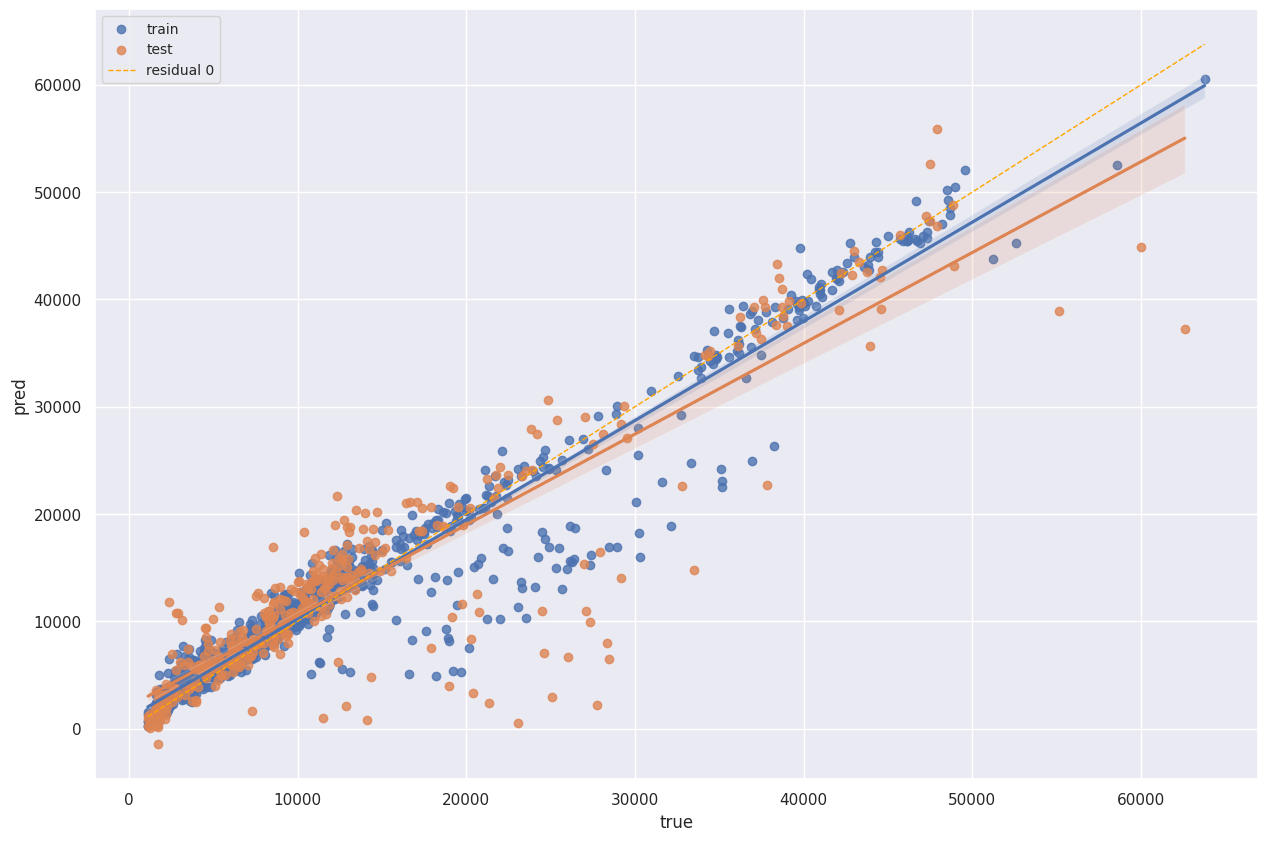

In [29]:
from xgboost.sklearn import XGBRegressor

for category in ['sex','smoker']:
    X_train[category] = X_train[category].astype('bool')
    X_test[category] = X_test[category].astype('bool')

for category in ['region']:
    X_train[category] = X_train[category].astype('int')
    X_test[category] = X_test[category].astype('int')

xgb_model = XGBRegressor(max_depth=3)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)  # 学習データを使って推論する
y_test_pred = xgb_model.predict(X_test)  # テストデータを使って推論する

evaluate_metrics(y_train_pred, y_test_pred)

# 残差の可視化を行うユーザー定義関数を呼び出す
residual_plot(y_train_pred, y_test_pred)

### 考察
- 明らかに過学習ですね

### さらなる精度改善3 (ボーナス+1点)
- この練習プログラムは加点要素です。ネットを検索してこれまでとは違うモデルを使い、精度改善にトライしてみましょう。
- 例：LightGBMを使用するトライ

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 316
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 6
[LightGBM] [Info] Start training from score 13174.146814
学習時スコア(train score)
　平均絶対誤差:  1596.8784937267994
　平均二乗誤差:  7088274.888703411
　二乗平均平方根誤差:  2662.381431858217
　決定係数R^2:  0.9522083879385745
テストスコア(test score)
　平均絶対誤差:  2924.6954995993156
　平均二乗誤差:  26646739.878972165
　二乗平均平方根誤差:  5162.048031447612
　決定係数R^2:  0.8141071099321107


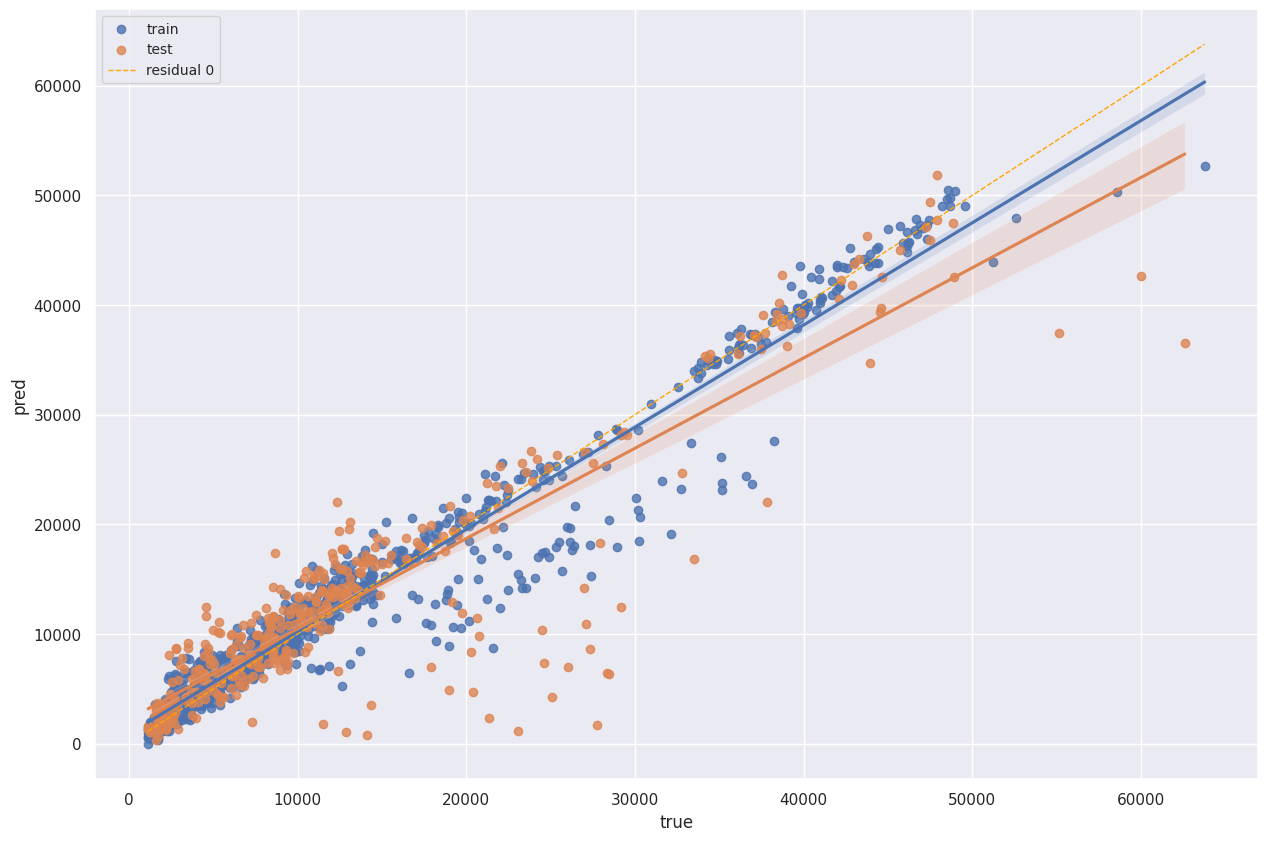

In [30]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor()
lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)  # 学習データを使って推論する
y_test_pred = lgb_model.predict(X_test)  # テストデータを使って推論する

evaluate_metrics(y_train_pred, y_test_pred)

# 残差の可視化を行うユーザー定義関数を呼び出す
residual_plot(y_train_pred, y_test_pred)

### 考察
- こちらも過学習ですね

---
---
---
---
---